# Plos Alternatives
## Binary Threshold + Volume Thresholding

After we discovered that the PLOS pipeline does not work for our data, we will now be switching to a simple binary threshold and volume threshold to remove background noise. We will begin with a binary threshold at different percentile cutoffs to see what value gives us the most relevant clusters. After connected components and the clusters are labeled, we will then use a volume threshold based off of Richard Roth's metrics to see whether the clusters remaining appear to be synapses.

### Pseudocode:
The algorithm will take in a raw image matrix and then run the intensity/volume thresholds.

**Inputs:** 
1. Raw image data
**Outputs:**
1. List of thresholded clusters.

**Function(data)**
    1. data = binaryThreshold(percentile, data)   #Binary thresholds image at certain percentile of intensities.
    2. clusters = connectedComponents(data)       #Clusters and labels remaining values into clusters.
    3. finalClusters = volumeThreshold(clusters)  #Clusters above or below certain volume metrics get removed.
    4. RETURN finalClusters                       #Returns list of final clusters     
    
### Algorithm Code:

In [21]:
import sys
sys.path.insert(0, '../code/functions/')
import connectLib as cLib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
from cluster import Cluster
from mpl_toolkits.mplot3d import Axes3D
import cv2
import mouseVis as mv
import tiffIO as tIO
from scipy import ndimage
from scipy import sparse

'''
dataSubset = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp2.tif'))[0][0:5]
plt.imshow(dataSubset[0], cmap="gray")
plt.show()
'''
#binary threshold
def binaryThreshold(img, percentile=90):
    img = (img/256).astype('uint8')
    threshImg = np.zeros_like(img)
    for i in range(len(img)):
        percentile = np.percentile(img[i], percentile)
        threshImg[i] = cv2.threshold(img[i], percentile, 255, cv2.THRESH_BINARY)[1]
    return threshImg

#Connected components and volume thresholding
def clusterThresh(volume, threshold=230, lowerThresh = 50):
    # the connectivity structure matrix
    s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]

    # find connected components
    labeled, nr_objects = ndimage.label(volume, s)

    #volume thresholding
    '''
    mask = labeled > labeled.mean()
    sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
    mask_size = sizes > threshold
    remove_pixel = mask_size[labeled]
    labeled[remove_pixel] = 0
    labeled, nr_objects = ndimage.label(labeled, s)
    '''
    #convert labeled to Sparse
    sparseLabeledIm = np.empty(len(labeled), dtype=object)
    for i in range(len(labeled)):
        sparseLabeledIm[i] = sparse.csr_matrix(labeled[i])
    
    clusterList = []

    #converting to clusterList
    for label in range(1, nr_objects + 1):

        memberList = []

        for z in range(len(sparseLabeledIm)):
            memberListWithoutZ = np.argwhere(sparseLabeledIm[z] == label)
            memberListWithZ = [[z] + list(tup) for tup in memberListWithoutZ]
            memberList.extend(memberListWithZ)

        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))
    #lower volume threshold
    for cluster in clusterList:
        if cluster.getVolume() < lowerThresh:
            clusterList.remove(cluster)
    return clusterList
    #upper volume threshold
    for cluster in clusterList:
        if cluster.getVolume() > upperThresh:
            clusterList.remove(cluster)
    return clusterList


def plosAlternative(data, percentile=90, upperThresh=200, lowerThresh=90):
    data = binaryThreshold(data, 90)
    clusterList = clusterThresh(data, upperThresh, lowerThresh)
    return clusterList

## Simulation Data
Almost the exact same simulation that we used for Precision&Recall as well as Connected Components. I generated a smaller volume size so plots are easier to analyze.  

Description: Validation testing will be performed on a a 50 x 50 x 50 volume. The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~1 micron ^3, or about 139 voxels (assuming the synthetic data here and the real world data have identical resolutions). Pixel intensity distributions are ignored in this simulation because we just want to study how the synapses are being clustered. Therefore, the correct "total" number of synapses is relatively unimportant compared to the ratio of true positives/false positives/ false negatives of our pipeline. In this simulation, synapses make up 8% of the data.

Evaluation: I will be evaluating each step in the pipeline through plot.ly graphs (look at it) and evaluating the final algorithm using Precision and Recall.

### Raw Synthetic Data:

In [5]:
from random import randrange as rand

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 5):
        for y in range(-1, 5):
            for x in range(-1, 5):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    clusterList = []
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
            potentialPointSet = generatePointSet()
            clusterList.append(Cluster(list(potentialPointSet)))
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume, clusterList

testVolume = generateTestVolume()
foreground = testVolume[0]
combinedIm = testVolume[1]
trueClusterList = testVolume[2]

## Displaying Simulation Data

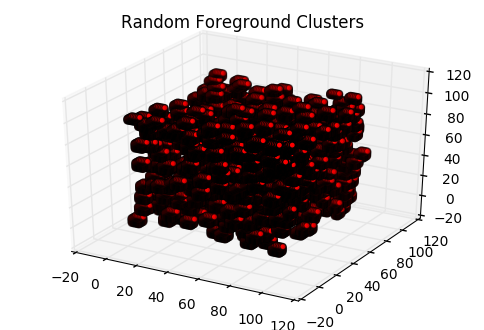

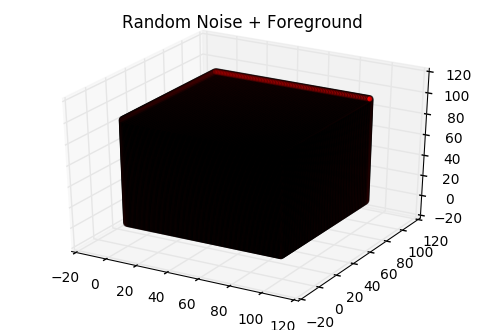

In [6]:
#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground Clusters')
plt.show()

#displaying the noise
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = combinedIm.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Noise + Foreground')
plt.show()

<Container object of 50 artists>

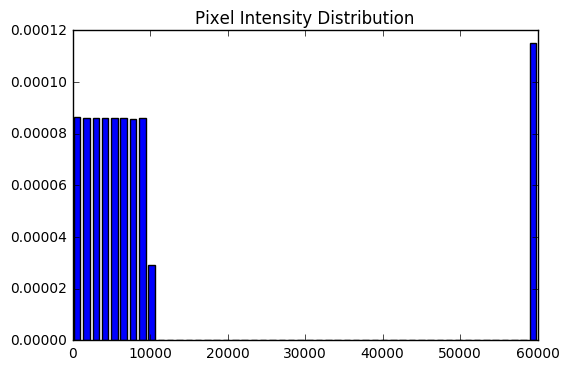

In [7]:
#displaying distribution of intensity
fig = plt.figure()
plt.title("Pixel Intensity Distribution")
hist, bins = np.histogram(combinedIm, bins=50, normed=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist, align='center', width=width)

In [8]:
print np.percentile(combinedIm, 90)

60000.0


### Why this Simulation is Good:
The 90th percentile of the pixel intensities is the value of our foreground clusters. That means the binary threshold should filter out all of the background. 


## Running Pipeline on Simulation:

In [18]:
clusters = plosAlternative(combinedIm, 90, 1000, 0)

In [19]:
print len(clusters)

1
